# **PINN Training**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 0, Loss: 3.954e-01
Epoch 100, Loss: 1.571e-01
Epoch 200, Loss: 1.119e-01
Epoch 300, Loss: 8.473e-02
Epoch 400, Loss: 8.426e-02
Epoch 500, Loss: 8.410e-02
Epoch 600, Loss: 8.402e-02
Epoch 700, Loss: 8.399e-02
Epoch 800, Loss: 8.400e-02
Epoch 900, Loss: 8.393e-02
Epoch 1000, Loss: 8.391e-02
Epoch 1100, Loss: 8.404e-02
Epoch 1200, Loss: 8.387e-02
Epoch 1300, Loss: 8.387e-02
Epoch 1400, Loss: 8.384e-02
Epoch 1500, Loss: 8.383e-02
Epoch 1600, Loss: 8.382e-02
Epoch 1700, Loss: 8.381e-02
Epoch 1800, Loss: 8.379e-02
Epoch 1900, Loss: 8.379e-02


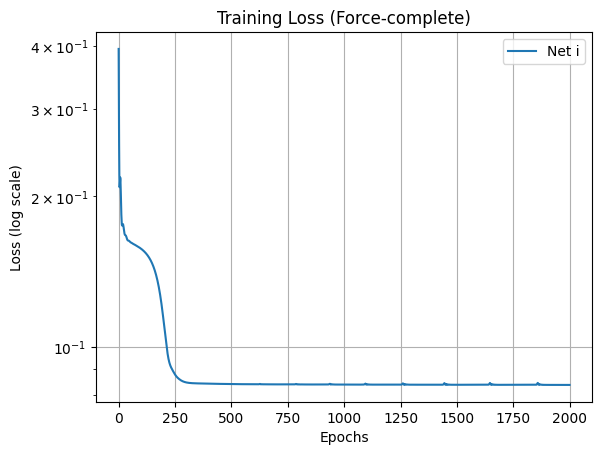

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Generate synthetic "force-complete" data
N = 10000
x = np.random.rand(N, 2)  # 2D domain (x, y)
λ_true, μ_true = 1.0, 0.5

# Define true displacement fields (for example)
def true_solution(xy):
    x, y = xy[:, 0], xy[:, 1]
    ux = np.sin(np.pi * x) * np.sin(np.pi * y)
    uy = np.cos(np.pi * x) * np.cos(np.pi * y)
    return ux[:, None], uy[:, None]

ux, uy = true_solution(x)
X_train = x
Y_train = np.hstack([ux, uy])

# Define PINN model (Net i: 5 hidden layers × 20 neurons)
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
    for _ in range(5):
        model.add(tf.keras.layers.Dense(20, activation='tanh'))
    model.add(tf.keras.layers.Dense(2))  # Output: ux, uy
    return model

model = create_model()

# Define physics-informed loss (simplified for ux, uy only)
def pinn_loss(model, x, true_u):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u_pred = model(x)
        ux_pred, uy_pred = u_pred[:, 0:1], u_pred[:, 1:2]
        du = tape.gradient(u_pred, x)
        du_dx = du[:, 0:1]
        du_dy = du[:, 1:2]
    mse_data = tf.reduce_mean(tf.square(u_pred - true_u))
    mse_phys = tf.reduce_mean(tf.square(du_dx)) + tf.reduce_mean(tf.square(du_dy))  # dummy physics term
    return mse_data + mse_phys

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
loss_history = []
X_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)

for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss_value = pinn_loss(model, X_tf, Y_tf)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    loss_history.append(loss_value.numpy())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy():.3e}")

# Plot loss history (like Fig. 5)
plt.semilogy(loss_history, label='Net i')
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Training Loss (Force-complete)')
plt.legend()
plt.grid(True)
plt.show()

